<a href="https://colab.research.google.com/github/YuriySamorodov/MIPT/blob/main/HW3_RPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Настройка окружения

In [1]:
# System wide libraries
import random
import warnings
from rich.progress import Progress
import time
import sys
import logging
import threading
import concurrent.futures
from threading import Lock
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import combinations
from typing import List, Dict, Tuple
from dataclasses import dataclass
from collections import defaultdict
from IPython.display import display, clear_output

In [2]:
!pip install -q -U kaggle_environments

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.7 MB/s eta 0:00:00


In [3]:
# DS libraries
import math
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import tqdm
from tqdm.notebook import tqdm_notebook
from kaggle_environments import make, evaluate

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Loading environment lux_ai_s3 failed: No module named 'gymnax'


> Нашел в коде параметр `tieRewardThreshold`. Он определяет минимальное количество побед, необходимое агенту для того, чтобы итог всех (например, 100) игр не был признан ничьей.
>
> Например, сли мы проводим 100 игр между двумя агентами, которые случайным образом выбирают камень, ножницы или бумагу, можно ожидать, что результаты обоих агентов не будут равны нулю. Вряд ли оба агента за 100 игр каждый раз будут делать одно и то же действие.
>
> Однако параметр `tieRewardThreshold` по умолчанию установлен на 20, что означает, что одному из агентов нужно одержать как минимум 20 побед, чтобы итог всех 100 игр не считался ничьей.
>
> Я везде изменил этот параметр на 1, чтобы сделать результаты более наглядными.

### 1. Агент, всегда игающий "камень"

In [4]:
%%writefile rock_agent.py

#0 - rock
#1 - paper
#2 - scissors
def rock_agent(observation, configuration):
    return 0

Writing rock_agent.py


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
evaluate(
    "rps", #environment to use - no need to change
    ["rock_agent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-98.0, 98.0]]

### 2. Агент, всегда играющий "бумагу"

In [6]:
%%writefile paper_agent.py

def paper_agent(observation, configuration):
    return 1

Writing paper_agent.py


In [7]:
evaluate(
    "rps", #environment to use - no need to change
    ["paper_agent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-97.0, 97.0]]

### 3. Агент, всегда играющий "ножницы"

In [8]:
%%writefile scissors_agent.py

def scissors_agent(observation, configuration):
    return 2

Writing scissors_agent.py


In [9]:
evaluate(
    "rps", #environment to use - no need to change
    ["scissors_agent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-99.0, 99.0]]

### 4. Агент всегда выбирает случайное значение

In [10]:
%%writefile random_opponent.py

import random

def random_opponent(observation, configuration):
    return random.randrange(0, configuration.signs)

Writing random_opponent.py


In [11]:
evaluate(
    "rps", #environment to use - no need to change
    ["random_opponent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-8.0, 8.0]]

### 5. Агент повторяет прошлый ход оппонента

In [12]:
%%writefile copy_opponent.py

import random

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent.py


In [13]:
evaluate(
    "rps", #environment to use - no need to change
    ["copy_opponent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-20.0, 20.0]]

### 6. Агент делает ход, отличный от противника (выбирает следующее действие)

In [14]:
%%writefile copynext_opponent.py

import random

def copynext_opponent(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % configuration.signs
    else:
        return random.randrange(0, configuration.signs)

Writing copynext_opponent.py


In [15]:
evaluate(
    "rps", #environment to use - no need to change
    ["copynext_opponent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[59.0, -59.0]]

### 7. Агент делает ход, отличный от противника (выбирает предыдущее действие)

In [16]:
%%writefile copyprevious_opponent.py

import random

def copyprevious_opponent(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % configuration.signs
    else:
        return random.randrange(0, configuration.signs)

Writing copyprevious_opponent.py


In [17]:
evaluate(
    "rps", #environment to use - no need to change
    ["copyprevious_opponent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-96.0, 96.0]]

### 8. Агент равновероятно играет то, что не выкинул противник на прошлом ходу

In [18]:
%%writefile opposit_agent.py

import random

def opposit_agent(observation, configuration):
    if observation.step > 0:
        if observation.lastOpponentAction == 0:
            return random.choice([1,2])
        elif observation.lastOpponentAction == 1:
            return random.choice([0,2])
        else:
            return random.choice([1,0])
    else:
        return random.randrange(0, configuration.signs)

Writing opposit_agent.py


In [19]:
evaluate(
    "rps", #environment to use - no need to change
    ["opposit_agent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-17.0, 17.0]]

### 9. Агент выбрасывает три раза одно и то же, после чего меняет выбор на следующее случайное

In [20]:
%%writefile random3_opponent.py

import random

counter = 0
stable_sign = None

def random3_opponent(observation, configuration):
    global counter
    global stable_sign
    if observation.step == 0:
        stable_sign = random.randrange(0, configuration.signs)
    elif counter % 3 == 2:
        stable_sign = random.randrange(0, configuration.signs)
    counter += 1
    return stable_sign

Writing random3_opponent.py


In [21]:
evaluate(
    "rps", #environment to use - no need to change
    ["random3_opponent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-17.0, 17.0]]

### 10. Агент производит то же действие, если выиграл, и меняет на следующее, если проиграл

In [22]:
%%writefile win_reaction1.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_reaction1(observation, configuration):
    global lastAction
    if observation.step == 0:
        lastAction = random.randrange(0, configuration.signs)
    elif get_score(lastAction, observation.lastOpponentAction) < 1:
        lastAction = (lastAction + 1) % configuration.signs
    return lastAction

Writing win_reaction1.py


In [23]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_reaction1.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[27.0, -27.0]]

### 11. Агент производит то же действие, если выиграл, и меняет на предыдущее, если проиграл

In [24]:
%%writefile win_reaction2.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_reaction2(observation, configuration):
    global lastAction
    if observation.step == 0:
        lastAction = random.randrange(0, configuration.signs)
    elif get_score(lastAction, observation.lastOpponentAction) < 1:
        lastAction = (lastAction + 2) % configuration.signs
    return lastAction

Writing win_reaction2.py


In [25]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_reaction2.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[59.0, -59.0]]

### 12. Агент производит то же действие, если выиграл, и меняет на действие противника, если проиграл

In [26]:
%%writefile win_opposit1.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_opposit1(observation, configuration):
    global lastAction
    if observation.step == 0:
        lastAction = random.randrange(0, configuration.signs)
    elif get_score(lastAction, observation.lastOpponentAction) < 1:
        lastAction = observation.lastOpponentAction
    return lastAction

Writing win_opposit1.py


In [27]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_opposit1.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-20.0, 20.0]]

### 13. Агент производит то же действие, если проиграл, и меняет на действие противника, если выиграл

In [28]:
%%writefile win_opposit2.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_opposit2(observation, configuration):
    global lastAction
    if observation.step == 0:
        lastAction = random.randrange(0, configuration.signs)
    elif get_score(lastAction, observation.lastOpponentAction) == 1:
        lastAction = observation.lastOpponentAction
    return lastAction

Writing win_opposit2.py


In [29]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_opposit2.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-93.0, 93.0]]

### 14. Агент производит то же действие, если выиграл, и меняет на случайное, если проиграл

In [30]:
%%writefile win_random1.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_random1(observation, configuration):
    global lastAction
    if observation.step == 0 or get_score(lastAction, observation.lastOpponentAction) < 1:
        lastAction = random.randrange(0, configuration.signs)
    return lastAction

Writing win_random1.py


In [31]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_random1.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[30.0, -30.0]]

### 15. Агент повторяет свой предущий ход, если проиграл, и меняет на случайное, если выиграл

In [32]:
%%writefile win_random2.py

import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

import random

lastAction = None

def win_random2(observation, configuration):
    global lastAction
    if observation.step == 0 or get_score(lastAction, observation.lastOpponentAction) == 1:
        lastAction = random.randrange(0, configuration.signs)
    return lastAction

Writing win_random2.py


In [33]:
evaluate(
    "rps", #environment to use - no need to change
    ["win_random2.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[-99.0, 99.0]]

### 16. Агент играет по очереди камень, бумагу, ножницы

In [34]:
%%writefile sequence_agent.py

counter = -1

def sequence(observation, configuration):
    global counter
    counter += 1
    if counter % 3 == 0:
        return 0
    elif counter % 3 == 1:
        return 1
    else:
        return 2

Writing sequence_agent.py


In [35]:
evaluate(
    "rps", #environment to use - no need to change
    ["sequence_agent.py", "statistical"], #agents to evaluate
    configuration={"episodeSteps": 100,
                   "tieRewardThreshold": 1} #number of episodes
)

[[1.0, -1.0]]

### Турнир

Воспользуемся функцией `evaluate` из библиотеки `kaggle_environments`. С её помощью запустим наших агентов и проведем эксперимент на заданном количестве игр

Составим список агентов, потом заставим их сыграть между собой по количеству партий.
Получившуюся статистику побед запишем в словарь и выведем в виде таблицы pandas

In [36]:
def run_rps_tournament(agents, num_rounds=3):
    """
    Run a Rock Paper Scissors tournament between multiple agents.

    Args:
        agents (list): List of agent filenames to compete
        num_rounds (int): Number of rounds for each matchup

    Returns:
        dict: Dictionary of agent rankings
    """
    # Initialize ranking dictionary
    rank = {agent: 0 for agent in agents}

    def evaluate_pair(pair):
        """Evaluate a pair of agents and return the winner."""
        agent1, agent2 = pair
        try:
            e = evaluate(
                "rps",  # Environment to use
                [agent1, agent2],  # Agents to evaluate
                configuration={"episodeSteps": 100, 'tieRewardThreshold': 1}
            )
            return (agent1, agent2, e[0][0], e[0][1])
        except Exception as exc:
            display(f"Match error ({agent1} vs {agent2}): {str(exc)}")
            return None

    # Generate all possible pairs of agents
    agent_pairs = list(combinations(agents, 2))
    matches_completed = 0
    total_matches = len(agent_pairs)

    # Display initial progress
    display(f"Starting tournament with {total_matches} matches...")

    # Use ThreadPoolExecutor for parallel evaluation
    with ThreadPoolExecutor() as executor:
        futures = []

        # Submit all pairs for evaluation
        for pair in agent_pairs:
            futures.append(executor.submit(evaluate_pair, pair))

        # Process results as they complete
        for future in futures:
            try:
                result = future.result()
                if result:
                    agent1, agent2, score1, score2 = result
                    matches_completed += 1

                    if score1 > score2:
                        rank[agent1] += 1
                    elif score1 < score2:
                        rank[agent2] += 1

                    # Update progress every 5 matches
                    if matches_completed % 5 == 0:
                        display(f"Progress: {matches_completed}/{total_matches} matches completed")

            except Exception as exc:
                display(f"Error processing match result: {str(exc)}")
                continue

    return dict(sorted(rank.items(), key=lambda x: x[1], reverse=True))

def display_tournament_results(rankings):
    """Display tournament results in a formatted way."""
    display("\nTournament Results:")
    display("-" * 50)
    display(f"{'Agent':<30} {'Score':<10}")
    display("-" * 50)

    for agent, score in rankings.items():
        display(f"{agent:<30} {score:<10}")

    display("-" * 50)

# List of agent scripts
agents = [
    'rock_agent.py',
    'paper_agent.py',
    'scissors_agent.py',
    'random_opponent.py',
    'copy_opponent.py',
    'copynext_opponent.py',
    'copyprevious_opponent.py',
    'opposit_agent.py',
    'random3_opponent.py',
    'win_reaction1.py',
    'win_reaction2.py',
    'win_opposit1.py',
    'win_opposit2.py',
    'win_random1.py',
    'win_random2.py',
    'sequence_agent.py'
]

try:
    # Run tournament
    rankings = run_rps_tournament(agents)

    # Display results
    display_tournament_results(rankings)

except Exception as e:
    display(f"Tournament error: {str(e)}")

'Starting tournament with 120 matches...'

'Progress: 5/120 matches completed'

'Progress: 10/120 matches completed'

'Progress: 15/120 matches completed'

'Progress: 20/120 matches completed'

'Progress: 25/120 matches completed'

'Progress: 30/120 matches completed'

'Progress: 35/120 matches completed'

'Progress: 40/120 matches completed'

'Progress: 45/120 matches completed'

'Progress: 50/120 matches completed'

'Progress: 55/120 matches completed'

'Progress: 60/120 matches completed'

'Progress: 65/120 matches completed'

'Progress: 70/120 matches completed'

'Progress: 75/120 matches completed'

'Progress: 80/120 matches completed'

'Progress: 85/120 matches completed'

'Progress: 90/120 matches completed'

'Progress: 95/120 matches completed'

'Progress: 100/120 matches completed'

'Progress: 105/120 matches completed'

'Progress: 110/120 matches completed'

'Progress: 115/120 matches completed'

'Progress: 120/120 matches completed'

'\nTournament Results:'

'--------------------------------------------------'

'Agent                          Score     '

'--------------------------------------------------'

'win_reaction2.py               12        '

'win_random1.py                 12        '

'copynext_opponent.py           10        '

'win_reaction1.py               10        '

'opposit_agent.py               8         '

'random3_opponent.py            8         '

'scissors_agent.py              7         '

'rock_agent.py                  6         '

'paper_agent.py                 6         '

'copy_opponent.py               6         '

'copyprevious_opponent.py       5         '

'win_opposit1.py                5         '

'win_random2.py                 5         '

'sequence_agent.py              4         '

'random_opponent.py             3         '

'win_opposit2.py                3         '

'--------------------------------------------------'

In [37]:
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)
print_lock = Lock()
rounds_count = 100
workers_count = 4

@dataclass
class MatchResult:
    agent1: str
    agent2: str
    score1: int
    score2: int

class TournamentStats:
    def __init__(self):
        self.wins = defaultdict(int)
        self.losses = defaultdict(int)
        self.points_scored = defaultdict(int)
        self.points_conceded = defaultdict(int)
        self.matches_played = defaultdict(int)

class RPSTournament:
    def __init__(self, agents: List[str], num_rounds: int = rounds_count, max_workers: int = workers_count):
        self.agents = agents
        self.num_rounds = num_rounds
        self.max_workers = max_workers
        self.rankings = defaultdict(int)
        self.matches_completed = 0
        self.total_matches = len(list(combinations(agents, 2)))
        self.rankings_lock = Lock()
        self.stats = TournamentStats()
        self.progress_bar = None

    def simulate_game(self, agent1: str, agent2: str) -> Tuple[int, int]:
        """Simulate a game between two agents."""
        score1 = 0
        score2 = 0

        for _ in range(self.num_rounds):
            move1 = self.get_move(agent1)
            move2 = self.get_move(agent2)

            if move1 == move2:
                continue
            elif (move1 == 'rock' and move2 == 'scissors') or \
                 (move1 == 'scissors' and move2 == 'paper') or \
                 (move1 == 'paper' and move2 == 'rock'):
                score1 += 1
            else:
                score2 += 1

        return score1, score2

    def get_move(self, agent: str) -> str:
        """Determine the move for an agent based on its name."""
        if 'rock' in agent.lower():
            return 'rock'
        elif 'paper' in agent.lower():
            return 'paper'
        elif 'scissors' in agent.lower():
            return 'scissors'
        else:
            return random.choice(['rock', 'paper', 'scissors'])

    def evaluate_match(self, pair: Tuple[str, str]) -> MatchResult:
        """Evaluate a single match between two agents."""
        agent1, agent2 = pair
        try:
            score1, score2 = self.simulate_game(agent1, agent2)
            return MatchResult(agent1, agent2, score1, score2)
        except Exception as exc:
            with print_lock:
                logger.error(f"Match error ({agent1} vs {agent2}): {str(exc)}")
            return None

    def update_stats(self, result: MatchResult) -> None:
        """Update tournament statistics."""
        self.stats.matches_played[result.agent1] += 1
        self.stats.matches_played[result.agent2] += 1

        self.stats.points_scored[result.agent1] += result.score1
        self.stats.points_scored[result.agent2] += result.score2

        self.stats.points_conceded[result.agent1] += result.score2
        self.stats.points_conceded[result.agent2] += result.score1

        if result.score1 > result.score2:
            self.stats.wins[result.agent1] += 1
            self.stats.losses[result.agent2] += 1
        elif result.score1 < result.score2:
            self.stats.wins[result.agent2] += 1
            self.stats.losses[result.agent1] += 1

    def process_match_result(self, result: MatchResult) -> None:
        """Process the result of a match and update rankings."""
        if result:
            with self.rankings_lock:
                if result.score1 > result.score2:
                    self.rankings[result.agent1] += 1
                elif result.score1 < result.score2:
                    self.rankings[result.agent2] += 1

                self.update_stats(result)
                self.matches_completed += 1

                # Update progress bar here if applicable.
                if self.progress_bar:
                    with print_lock:  # Use a lock for thread safety.
                        self.progress_bar.update(1)

    def run(self) -> Dict[str, int]:
        """Run the tournament with parallel processing."""
        logger.info(f"Starting tournament with {self.total_matches} matches...")

        agent_pairs = list(combinations(self.agents, 2))

        with tqdm_notebook(total=self.total_matches, desc="Tournament Progress") as self.progress_bar:
            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = {executor.submit(self.evaluate_match, pair): pair for pair in agent_pairs}

                for future in as_completed(futures):
                    try:
                        result = future.result()
                        self.process_match_result(result)
                    except Exception as exc:
                        logger.error(f"Error processing match: {str(exc)}")
                        # Ensure progress bar updates even on error.
                        with print_lock:
                            self.progress_bar.update(1)

        return dict(sorted(
            self.rankings.items(),
            key=lambda x: x[1],
            reverse=True
        ))

    def get_stats_dataframe(self) -> pd.DataFrame:
        """Create a DataFrame with tournament statistics."""
        data = []

        for agent in self.agents:
            matches_played = self.stats.matches_played[agent]
            win_rate = (self.stats.wins[agent] / matches_played * 100) if matches_played > 0 else 0
            points_per_match = (self.stats.points_scored[agent] / matches_played) if matches_played > 0 else 0

            data.append({
                'Agent': agent.replace('.py', ''),
                'Matches': matches_played,
                'Wins': self.stats.wins[agent],
                'Losses': self.stats.losses[agent],
                'Win Rate %': round(win_rate, 1),
                'Points Scored': self.stats.points_scored[agent],
                'Points Conceded': self.stats.points_conceded[agent],
                'Points/Match': round(points_per_match, 1)
            })

        return pd.DataFrame(data).sort_values('Win Rate %', ascending=False)


In [38]:
def run_tournament(agents: List[str], num_rounds: int = rounds_count, max_workers: int = workers_count) -> Tuple[Dict[str, int], RPSTournament]:
    """Wrapper function to run tournament safely."""
    try:
        tournament = RPSTournament(agents, num_rounds=num_rounds, max_workers=max_workers)
        rankings = tournament.run()
        return rankings, tournament  # Return both rankings and tournament instance
    except Exception as e:
        logger.error(f"Tournament error: {str(e)}")
        return {}, None  # Return None for tournament in case of error



In [39]:
def display_results(tournament: RPSTournament) -> None:
    """Display tournament results with visualizations."""
    # Get stats DataFrame
    stats_df = tournament.get_stats_dataframe()

    # Display styled table
    display(stats_df.style
           .background_gradient(subset=['Win Rate %'], cmap='RdYlGn')
           .background_gradient(subset=['Points/Match'], cmap='RdYlGn')
           .format({
               'Win Rate %': '{:.1f}%',
               'Points/Match': '{:.1f}'
           }))

    # Create visualization for Win Rate Bar Plot
    plt.pyplot.figure(figsize=(15, 8))

    plt.pyplot.subplot(1, 2, 1)
    #plt.pyplot.subplots_adjust(hspace=0.5, bottom=0.5, top=0.6)
    sns.barplot(data=stats_df, x='Win Rate %', y='Agent', palette='viridis', hue='Agent', legend=False)
    plt.pyplot.title('Win Rate by Agent')
    plt.pyplot.xlabel('Win Rate (%)')

    plt.pyplot.subplot(1, 2, 1)


    # Create visualization for Points per Match Bar Plot
    plt.pyplot.subplot( 1, 2, 2)
    sns.barplot(data=stats_df, x='Points/Match', y='Agent', palette='viridis', hue='Agent', legend=False)
    plt.pyplot.title('Points per Match by Agent')
    plt.pyplot.xlabel('Points per Match')

    plt.pyplot.tight_layout()
    plt.pyplot.show()

In [40]:
# List of agents (same as before)
agents = [
    'rock_agent.py',
    'paper_agent.py',
    'scissors_agent.py',
    'random_opponent.py',
    'copy_opponent.py',
    'copynext_opponent.py',
    'copyprevious_opponent.py',
    'opposit_agent.py',
    'random3_opponent.py',
    'win_reaction1.py',
    'win_reaction2.py',
    'win_opposit1.py',
    'win_opposit2.py',
    'win_random1.py',
    'win_random2.py',
    'sequence_agent.py'
]

# Run the tournament and get both rankings and tournament instance
rankings, tournament = run_tournament(agents)


Tournament Progress:   0%|          | 0/120 [00:00<?, ?it/s]

# ИТОГОВЫЙ РЕЙТИНГ

,Agent,Matches,Wins,Losses,Win Rate %,Points Scored,Points Conceded,Points/Match
3,random_opponent,15,9,5,60.0%,545,480,36.3
13,win_random1,15,9,6,60.0%,524,484,34.9
14,win_random2,15,9,4,60.0%,532,462,35.5
0,rock_agent,15,8,6,53.3%,548,535,36.5
2,scissors_agent,15,8,5,53.3%,542,515,36.1
8,random3_opponent,15,8,7,53.3%,512,489,34.1
11,win_opposit1,15,8,6,53.3%,518,527,34.5
1,paper_agent,15,7,6,46.7%,535,509,35.7
6,copyprevious_opponent,15,7,8,46.7%,490,521,32.7
9,win_reaction1,15,7,7,46.7%,493,486,32.9


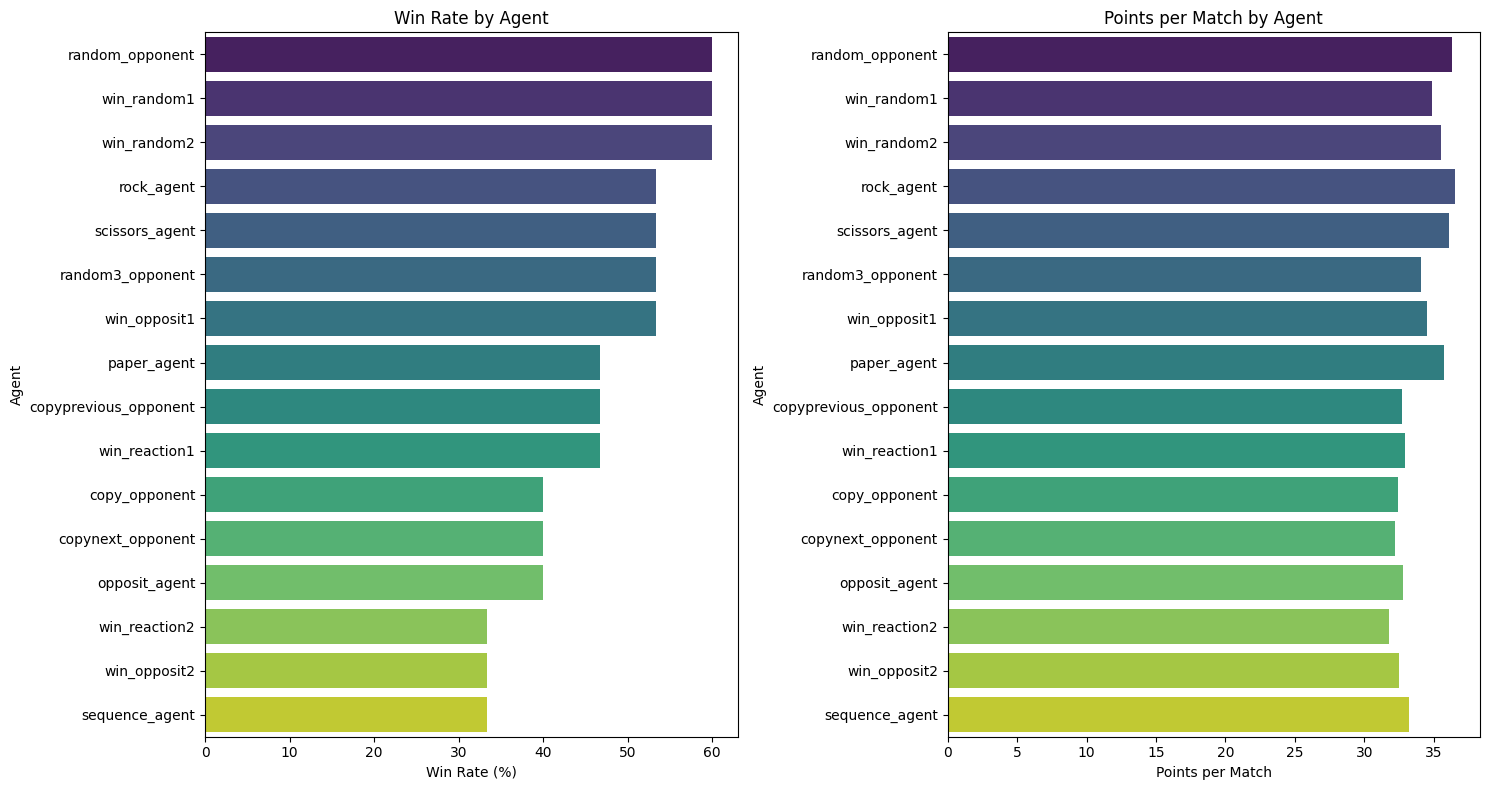

In [41]:
# Check if tournament is not None before displaying results
if tournament:
    display_results(tournament)

In [ ]:
rank_se = pd.Series(rankings, name="Рейтинг турнира по количеству выигранных партий").sort_values(ascending=False).to_frame()
rank_se